In [15]:
#Function to get isolines from the Here API. 
from shapely.geometry import Polygon
import requests
import geopandas as gpd
from geopandas import GeoSeries
import folium
import citydelconfig as config
import pandas as pd
google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key

name = "hereapi"
ID = config.here_api_key
CODE = config.here_api_code

head = 'https://isoline.route.cit.api.here.com/routing/7.2/calculateisoline.json?'
URL_Base = '{}app_id={}&app_code={}&mode=fastest;{};traffic:{}&start=geo!{},{}&range={}&rangetype={}'
URL_Base_dep = '{}app_id={}&app_code={}&mode=fastest;{};traffic:{}&departure={}&start=geo!{},{}&range={}&rangetype={}'

def get_isodata(location, type_iso = 'time', range_iso = 3600, travel_mode = 'car', traffic='disabled', departure=None): #receives a single location
    """ Function uses Here API to generate isolines depending on input parameters
    
    Parameters:
    location - Tuple of coordinates (lat, long)
    type_iso - Type of isoline, distance or time based, defaults to time
    range_iso - Range of the isoline depending on type_iso (in seconds), defaults to 1 hour
    travel_mode - Type of transit, can be truck, car or pedestrian
    traffic - toggles enabled or disabled
    departure - Departure time in format YYYY-MM-DDTHH:MM:SS (can include timezone)
    """
    
    if departure == None:
        url = URL_Base.format(head, ID, CODE, travel_mode, traffic, location[0], location[1], range_iso, type_iso) 
    else: 
        url = URL_Base_dep.format(head, ID, CODE, travel_mode, traffic, departure, location[0], location[1], range_iso, type_iso)
    try: 
        js = requests.get(url).json()['response']
        iso = js['isoline']
        coords = Polygon([(float(x.split(',')[1]), float(x.split(',')[0])) for x in iso[0]['component'][0]['shape']])
        geojs = gpd.GeoSeries([coords])
        geojs.crs = {'init' : 'epsg:4326'}
        return geojs
    except KeyError:
        js = requests.get(url).json()
        print(js)
        raise ValueError("HereAPI doesn't have data requested")
    except IndexError:
        print(js)
        raise ValueError("HereAPI doesn't have quality data")

In [16]:
def iso_function(features):
    return {'fillOpacity': 0.1, 'weight': 3, 'fillColor': 'blue'}

def iso_function_shp(features):
    return {'fillOpacity': 0.2, 'weight': 3, 'color' : 'red', 'fillColor': 'red'}


def isoplot(center, locations, shp=None, outputfile = 'out.html'):
    """ Function creates a plot of the isoline on top of a map
    
    Parameters:
    center - Center for the map to be created (lat, long)
    locations - Geoseries/Geodataframe of isoline/isolines
    shp - Geoseries/Geodataframe of a city shapefile to overlay on top of the isolines
    outputfile - Output location in .html extension
    """
    fm = folium.Map(location = center, zoom_start=8, tiles='CartoDBPositron')
    geojson = locations.__geo_interface__
    folium.GeoJson(geojson, style_function = iso_function).add_to(fm)
    if not shp is None:
        geojson = shp.__geo_interface__
        folium.GeoJson(geojson, style_function = iso_function_shp).add_to(fm)
    fm.save(outputfile)
    print('map saved to %s' %outputfile)

In [17]:
#secondary functions for different types of input data to plot
    
def isoplot_contour(center, locations, outputfile):
    #takes a center, and a list of isolines to create a contour map
    fm = folium.Map(location = center, zoom_start = 10, tiles = 'CartoDBPositron')
    for loc in locations:
        geojson = loc.__geo_interface__
        geojson['style'] = {"__comment": "all SVG styles allowed", "fill":"red", "stroke-width":"3", "fill-opacity":0.6}
        folium.GeoJson(geojson).add_to(fm)
    fm.save(outputfile)
    print('map saved to %s' %outputfile)
    
def get_isodata_list(locations, range_iso = 3600, type_iso = 'time', traffic = 'disabled'): 
    #recevies many locations, as a list of tuples of locations
    isoclines = []
    for loc in locations: 
        try:
            line = get_isodata(loc, range_iso, type_iso, traffic)
            isoclines.append(line)
        except ValueError:
            pass
    return isoclines

        
def make_list(centers, names, color, range_iso = 3600, type_iso = 'time', traffic = 'disabled'):
    for i, center in enumerate(centers):
        try:
            line = get_isodata(center, range_iso, type_iso, traffic)    
        except ValueError:
            pass
        isoplot(center, line, 'red', 'isoclines/' + names[i] +'.html')

In [31]:
#examples of using get_isodata and isoplot for Chicago
chicago_center = (41.881832, -87.623177)
chicago_iso = get_isodata(chicago_center, traffic='enabled', departure='2019-02-13T17:00:00')
isoplot(chicago_center, chicago_iso, outputfile = 'chicago.html')



map saved to chicago.html


<img src="Screenshots/chicago_isoline_1hr.png" />

In [20]:
#Get many isolines for a location for a range of times

def get_contour_series(center):
    locs_all = []
    for time in range(600, 9000, 600):
        locs_at_time = get_isodata(center, range_iso = time, traffic='enabled', departure='2019-02-13T16:00:00')
        locs_all.append(locs_at_time[0]) 
    locs_geo = GeoSeries([a for a in locs_all])
    locs_geo.crs = {'init': 'epsg:4326'}
    return locs_geo

In [62]:
#Importing CBSA Shapefile Data
us_shp_fp = "tl_2017_us_cbsa/tl_2017_us_cbsa.shp"
cbsa_data = gpd.read_file(us_shp_fp)
cbsa_data = cbsa_data.to_crs({'init' : 'epsg:4326'})

#Getting Chicago shapefile
chicago_cbsa = cbsa_data[cbsa_data['NAME'].str.contains('Chicago')]
chicago_cbsa = chicago_cbsa.reset_index()

#Creating a isoline contour map 
chicago_iso_contour = get_contour_series(chicago_center)

#Plotting this data
isoplot(chicago_center, chicago_iso_contour, chicago_cbsa, 'chicago.html')

map saved to chicago.html


<img src="Screenshots/chicago_contour_series.png" alt="drawing" width="500">

In [25]:
#examples of using get_isodata and isoplot for different cities and times

abad_center = (23.027496, 72.572697)
locsabad = get_isodata(abad_center, range_iso = 3600, type_iso = 'time')
isoplot(abad_center, locsabad, outputfile = 'abad.html')
locsabad2 = get_isodata(abad_center, traffic='enabled', departure='2019-02-13T17:00:00')
isoplot(abad_center, locsabad2, outputfile = '../abad_traffic.html')

mumbai_center = (19.060828, 72.872478)
locs = get_isodata(mumbai_center, traffic='enabled', departure='2019-02-13T17:00:00')
isoplot(mumbai_center, locs, outputfile = 'mumbai_traffic.html')
locs2 = get_isodata(mumbai_center, traffic='disabled', departure = '2019-02-13T23:00:00')
isoplot(mumbai_center, locs2, outputfile = 'mumbai_notraffic2.html')



#hereapi.isoplot(home, locs,'red','out.html')

map saved to abad.html
map saved to ../abad_traffic.html
map saved to mumbai_traffic.html
map saved to mumbai_notraffic2.html


In [72]:
#Returns area of a geoseries in square kilometers
def geoseries_area(geoser):
    area_ser = geoser.to_crs({'proj':'cea'})
    area = area_ser.area
    total_area = 0
    for index, value in area.iteritems():
        total_area += value
    return (total_area / 10**6)

geoseries_area(chicago_iso)


2280.6511480875533

In [34]:
#Reads in Oecd Functional urban areas and the function returns the shapefile for a desired
#city by fuaname 

chicago_center = (41.8781136, -87.6297982)
us_shp_fp = "United States/United States.shp"
oecd_data = gpd.read_file(us_shp_fp)

def return_cityshp_oecd(city_name):
    shp =  oecd_data[oecd_data.fuaname == city_name]
    shp = shp.reset_index()
    geoshp = shp.geometry
    geoshp.crs = {'init' :'epsg:4326'}
    return geoshp
        

chicago_shp = return_cityshp_oecd('Chicago')

In [35]:
#Reads in US_counties shapefiles
US_counties_name = 'tl_2018_us_county/tl_2018_us_county.shp'
US_counties = gpd.read_file(US_counties_name)
US_counties.crs = {'init' : 'epsg:4326'} 


In [73]:
#Returns the marginal percentage areas that each isoline covers a city shapefile until the
#isoline no longer reaches anymore city area. Each iteration increases isoline by 10 minutes. 
#Note, in city shapefiles with water, the sum may not add up to 1. 

def cumulative_areas(center, oecd_shape):
    used_shape = oecd_shape.copy()
    oecd_area = geoseries_area(used_shape)
    overlap = 10000
    time = 600
    data_list = []
    cumu_area = overlap/oecd_area 
    while (cumu_area > 0):
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T16:00:00')
        overlap = geoseries_area(isoline.intersection(used_shape))
        cumu_area = overlap/oecd_area
        data_list.append((time/60, cumu_area))
        used_shape = used_shape.difference(isoline)
        time += 600
    return data_list

data = cumulative_areas(chicago_center, chicago_cbsa)
data

[(10.0, 0.0008767868972554838),
 (20.0, 0.003650634457769277),
 (30.0, 0.005844973981935764),
 (40.0, 0.008643950253130082),
 (50.0, 0.019373340690046804),
 (60.0, 0.04301391208737764),
 (70.0, 0.06176769406290778),
 (80.0, 0.08677485443928551),
 (90.0, 0.11058139412139946),
 (100.0, 0.12973987514479557),
 (110.0, 0.13538943647254204),
 (120.0, 0.11754530781227959),
 (130.0, 0.04758064810423298),
 (140.0, 0.00347895730287835),
 (150.0, 0.009346177910494951),
 (160.0, 0.0)]

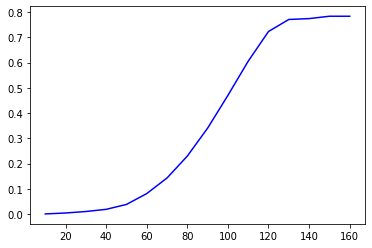

In [53]:
#Plots data produced by cumulative_areas function
import numpy as np
import matplotlib.pyplot as plt

def plot_cumu_data(data):
    plt.plot([i[0] for i in data], np.cumsum([i[1] for i in data]), c='blue')
    
plot_cumu_data(data)

In [63]:
#Returns the intersection over union of the biggest isoline produced by the 
#cumulative_areas function

def intersection_union(center, cum_areas, oecd_shape):
    time,v = cum_areas[-1]
    time = int(time) * 60
    isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T16:00:00')
    intersection = geoseries_area(isoline.intersection(oecd_shape))
    union = geoseries_area(isoline.union(oecd_shape))
    return intersection/union

intersection_union(chicago_center, data, chicago_cbsa)


0.25518756770720585

In [81]:
#Returns cumulative_areas data and intersection over union data for a selection of metros
#area larger than 20037776415 square meters

def metros_cumu_areas(cbsa_data): 
    is_metro = cbsa_data['LSAD'] == 'M1'
    metros = cbsa_data[is_metro]
    is_big = metros['ALAND'] > 20037776415
    big_metros = metros[is_big]
    metros = big_metros.reset_index()
    CBSAFP = []
    names = []
    coords = []
    shapefiles = []
    cumu_areas = []
    iou_biggest = []
    for i, row in metros.iterrows():
        names.append(row['NAME'])
        CBSAFP.append(row['CBSAFP'])
        coords.append((float(row['INTPTLAT']), float(row['INTPTLON'])))
        geoshp = GeoSeries(row['geometry'])
        geoshp.crs = {'init' :'epsg:4326'}
        shapefiles.append(geoshp)
        try:
            cumu_area = cumulative_areas(coords[i], shapefiles[i])
            cumu_areas.append(cumu_area)
            iou_biggest.append(intersection_union(coords[i], cumu_area, shapefiles[i]))
        except ValueError:
            cumu_area = [(0,0)]
            cumu_areas.append(cumu_area)
            iou_biggest.append(0.0)
    IOU_d = {'CBSAFP': CBSAFP, 'Names' : names, 'IOU' : iou_biggest}
    IOU_data = pd.DataFrame(data=IOU_d)
    CBSAFP_cumu = []
    names_cumu = []
    cumu_times_opened = []
    cumu_percents_opened = []
    for i, table in enumerate(cumu_areas):
        for time, percent in table:
            CBSAFP_cumu.append(CBSAFP[i])
            names_cumu.append(names[i])
            cumu_times_opened.append(time)
            cumu_percents_opened.append(percent)
    CA_d = {'CBSAFP' : CBSAFP_cumu, 'Names' : names_cumu, 
            'Isoline Time Buckets' : cumu_times_opened, 
            'Percentages' : cumu_percents_opened}
    CA_data = pd.DataFrame(data = CA_d)
    CA_data.to_csv('CA_data.csv')
    IOU_data.to_csv('IOU_data.csv')
    return IOU_data, CA_data

iou, cumu_areas = metros_cumu_areas(cbsa_data)

{'_type': 'ns2:RoutingServiceErrorType', 'type': 'ApplicationError', 'subtype': 'InvalidInputData', 'details': 'Range is limited to 32400s. This limit might change in future releases.', 'additionalData': [{'key': 'range', 'value': '33000'}], 'metaInfo': {'timestamp': '2019-08-19T16:32:58Z', 'mapVersion': '8.30.99.152', 'moduleVersion': '7.2.201931-4786', 'interfaceVersion': '2.6.66', 'availableMapVersion': ['8.30.99.152']}}
{'response': {'metaInfo': {'timestamp': '2019-08-19T16:34:57Z', 'mapVersion': '8.30.99.152', 'moduleVersion': '7.2.201931-4786', 'interfaceVersion': '2.6.66', 'availableMapVersion': ['8.30.99.152']}}}


In [84]:
print(iou.head())
print(cumu_areas.head())


  CBSAFP           Names  Isoline Time Buckets  Percentages
0  39660  Rapid City, SD                  10.0     0.000401
1  39660  Rapid City, SD                  20.0     0.001072
2  39660  Rapid City, SD                  30.0     0.008514
3  39660  Rapid City, SD                  40.0     0.024494
4  39660  Rapid City, SD                  50.0     0.033574
  CBSAFP                                  Names       IOU
0  39660                         Rapid City, SD  0.232656
1  40140   Riverside-San Bernardino-Ontario, CA  0.000000
2  41180                       St. Louis, MO-IL  0.275558
3  46060                             Tucson, AZ  0.215484
4  35620  New York-Newark-Jersey City, NY-NJ-PA  0.124216


However this data needs to be improved on in a few ways. The iou's are just the largest iou's and the cut off for cities is fairly arbitrary. The next functions are used to create data tables that are more useful ways of using the data functions. 

In [95]:
#Function returns a data frame consisting of the marginal population and areas of each
#isoline increasing in 10 minutes. The function is given co-ordinates of the center of cities
#and runs until it reaches 98% percentage of the city. 

import censusdata
from census import Census

bg_name = 'BG/tl_2018_{}_bg/tl_2018_{}_bg.shp'
pop_code = 'B01003_001E'
c = Census(config.census_api_key)

def isoline_pops(center, city_shape):
    used_shape = city_shape.copy()
    big_isoline = get_isodata(center, range_iso = 9000)
    used_shape = big_isoline.intersection(used_shape)
    city_area = geoseries_area(city_shape)
    count = 0
    zero_count = 0
    overlap = 10000
    time = 600
    times = []
    marginal_pops = []
    containments = []
    cumu_pops = []
    cumu_area = overlap/city_area 
    cumu_areas = []
    IOU_list = []
    areas = []
    geometries = []
    merged = gpd.GeoDataFrame()
    states = []
    state_data = []
    states_read = dict()
    st_county_read = dict()
    while (sum(cumu_areas) < 0.98 and count<24 and zero_count < 3): 
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T16:00:00')
        intersection = geoseries_area(isoline.intersection(city_shape))
        containment = (intersection/city_area) * intersection/(geoseries_area(isoline))
        containments.append(containment)
        union = geoseries_area(isoline.union(city_shape))
        IOU_list.append(intersection/union)
        if count == 0:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline)
            isoline_gdf.crs = {'init':'epsg:4326'}
        else:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline.difference(prev_isoline))
            isoline_gdf.crs = {'init':'epsg:4326'}
        states = gpd.sjoin(US_counties, isoline_gdf, op="intersects").STATEFP.unique()
        for state in states:
            if state in states_read.keys():
                pass
            else:
                bg_new = gpd.read_file(bg_name.format(state,state))
                bg_new.crs = ({'init':'epsg:4326'})
                states_read[state] = bg_new
                merged = pd.concat([merged, bg_new])
        marginal_pops.append(0)
        current_iso = gpd.sjoin(merged, isoline_gdf, op='intersects')
        for index, row in current_iso.iterrows():
            state_county = row['STATEFP'] + row['COUNTYFP']
            if not (state_county) in st_county_read.keys():
                st_county_read[state_county] = dict()
                county_bg_data = c.acs5.state_county_blockgroup(pop_code, row['STATEFP'], row['COUNTYFP'], Census.ALL)
                for d in county_bg_data:
                    st_county_read[state_county][state_county + d['tract'] + d['block group']] = d[pop_code]
            marginal_pops[count] += st_county_read[state_county][row['GEOID']]
            isoline = isoline.union(row['geometry'])
        overlap = geoseries_area(isoline.intersection(used_shape))
        geometries.append(isoline[0])
        times.append(time/60)
        areas.append(geoseries_area(isoline))
        cumu_area = overlap/city_area
        if cumu_area == 0:
            zero_count += 1
        cumu_areas.append(cumu_area)
        used_shape = used_shape.difference(isoline)
        if count == 0:
            prev_isoline = gpd.GeoDataFrame(geometry = isoline)
            prev_isoline.crs = {'init' : 'epsg:4326'}
        else :
            prev_isoline = gpd.GeoDataFrame(geometry = prev_isoline.union(isoline))
            prev_isoline.crs = {'init' : 'epsg:4326'}
        time += 600
        count += 1
    optima = []
    largest_IOU = []
    cumu_pop = 0
    for index, num in enumerate(marginal_pops):
        try:
            if num > marginal_pops[index+1] and num > marginal_pops[index-1]:
                optima.append(1)
            else:
                optima.append(0)
        except IndexError:
            optima.append(0)
        cumu_pop += num
        cumu_pops.append(cumu_pop)
        if max(IOU_list) == IOU_list[index]:
            largest_IOU.append(1)
        else:
            largest_IOU.append(0)
    return_dict = {'Times' : times, 
                   'Cumulative_Areas' : cumu_areas, 
                   'Areas' : areas,
                   'Marginal_Population' : marginal_pops,
                   'Cumulative_Population' : cumu_pops,
                  'Optima' : optima,
                  'IoU' : IOU_list,
                  'IOU_Largest': largest_IOU}
    return_frame = pd.DataFrame(data = return_dict)
    return return_frame
                

In [96]:
isoline_pops(chicago_center, chicago_cbsa)

,Times,Cumulative_Areas,Areas,Marginal_Population,Cumulative_Population,Optima,IoU,IOU_Largest
0,10.0,1.654568e-03,41.047076,202752.0,202752.0,0,0.000877,0
1,20.0,9.633505e-03,1859.922498,622859.0,825611.0,0,0.004527,0
2,30.0,6.115274e-03,287.270972,1003183.0,1828794.0,0,0.010372,0
3,40.0,1.477389e-02,848.516436,1131286.0,2960080.0,0,0.019016,0
4,50.0,2.336417e-02,1145.170032,1177564.0,4137644.0,0,0.038390,0
5,60.0,4.989304e-02,6318.259602,1481567.0,5619211.0,0,0.081395,0
6,70.0,8.495369e-02,6727.670478,1500605.0,7119816.0,0,0.143127,0
7,80.0,1.015989e-01,10111.443920,1536600.0,8656416.0,0,0.228499,0
8,90.0,1.360828e-01,17134.707716,1633294.0,10289710.0,1,0.326194,0
9,100.0,1.341417e-01,21219.533274,1175663.0,11465373.0,0,0.430464,0


In [99]:
#Takes in a string of city and state and returns the coordinates depending on the google pin
#of the city location given.

def get_google_coords(city, state):
    google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key
    url = google_api.format(city, state)
    js = requests.get(url).json()['results'][0]['geometry']
    lat = js['location']['lat']
    long = js['location']['lng']
    coords = (float(lat), float(long))
    return coords

In [100]:
#Takes in list of cities with index, city name, state abbreviation as well as CBSA shapefiles
#and returns a dataframe of each cities with their marginal populations, cumulative areas, 
#local optima 

import re
google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key
with open('top_cities.txt', 'r') as f:
        cities = f.readlines()

def top_30_pop_data(cities, cbsa_data):
    car_data_30 = pd.DataFrame()
    for row in cities:
        metro = row.split(',')
        city = metro[1]
        state = metro[2]
        is_metro = cbsa_data['LSAD'] == 'M1'
        metro_data = cbsa_data[is_metro]
        metro_data = metro_data[metro_data['NAME'].str.contains(city)]
        if len(metro_data) != 1:
            shp = metro_data[metro_data['NAME'].str.contains(state)]
        else:
            shp = metro_data[metro_data['NAME'].str.contains(city)]
        shp = shp.reset_index()
        geoshp = GeoSeries(shp['geometry'])
        geoshp.crs = {'init' : 'epsg:4326'}
        city = re.sub(r'\s+', '+', city)
        city = city.replace('.', '')
        coords = get_google_coords(city, state)
        pop_data = isoline_pops(coords, geoshp)
        cbs_list = []
        name_list = []
        for a in range(0, len(pop_data)):
            cbs_list.append(shp['CBSAFP'][0])
            name_list.append(shp['NAME'][0])
        pop_data.insert(loc = 0, column = 'CBSAFP', value=cbs_list)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        car_data_30 = pd.concat([car_data_30, pop_data], sort=False)
        car_data_30.to_csv('car_data_ 4pm.csv')

Function was used to create charts below, using ggplot2 in R: 
<img src="Screenshots/Top_10_pop_vs_time.png" alt="drawing" width="500"/>
<img src="Screenshots/iou_vs_time.png" alt="drawing" width="500"/>

In [101]:
#Performs calculations about the fitness of isolines and how well they match up to shapefiles 
#given to the functions. Examples below are shown using different forms of shapefiles, 
#cbsa and urban areas definitions, #Fitness is defined as percentage of area of isoline
#within city boundaries

def isoline_contains(center, city_shape):
    time = 600
    times = []
    fitness = []
    areas_both = []
    areas_only_isoline = []
    isoline_areas = []
    while(time<9000):
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-12T16:00:00')
        isoline_gdf = gpd.GeoDataFrame(geometry = isoline)
        intersection = gpd.overlay(isoline_gdf, city_shape, how = 'intersection')
        intersection_area = geoseries_area(intersection)
        isoline_area = geoseries_area(isoline)
        areas_only_isoline.append(isoline_area-intersection_area)
        fitness.append(intersection_area/isoline_area)
        isoline_areas.append(isoline_area)
        areas_both.append(intersection_area)
        times.append(time/60)
        time += 600
        print(time)
    largest_IOU = []
    for index, num in enumerate(fitness):
        if max(fitness) == fitness[index]:
            largest_IOU.append(1)
        else:
            largest_IOU.append(0)
    return_dict = {'Times' : times, 
                   'Fitness' : fitness, 
                   'Isoline_Area' : isoline_areas,
                   'Intersection' : areas_both,
                    'Only_Isoline' : areas_only_isoline,
                  'Greatest Fitness': largest_IOU}
    return_frame = pd.DataFrame(data = return_dict)
    return return_frame
    

In [102]:
#Returns fitness data on the top 30 cities list used above. Data produced using this function
#is charted below

import re

def top_30_contain_data(cities, cbsa_data):
    with open('top_cities.txt', 'r') as f:
        cities = f.readlines()
    car_data_30 = pd.DataFrame()
    for row in cities:
        metro = row.split(',')
        city = metro[1]
        state = metro[2]
        is_metro = cbsa_data['LSAD'] == 'M1'
        metro_data = cbsa_data[is_metro]
        metro_data = metro_data[metro_data['NAME'].str.contains(city)]
        if len(metro_data) != 1:
            shp = metro_data[metro_data['NAME'].str.contains(state)]
        else:
            shp = metro_data[metro_data['NAME'].str.contains(city)]
        shp = shp.reset_index()
        geoshp = GeoSeries(shp['geometry'])
        geoshp.crs = {'init' : 'epsg:4326'}
        city = re.sub(r'\s+', '+', city)
        city = city.replace('.', '')
        coords = get_google_coords(city, state)
        #try:
        pop_data = isoline_contains(coords, geoshp)
        cbs_list = []
        name_list = []
        for a in range(0, len(pop_data)):
            cbs_list.append(shp['CBSAFP'][0])
            name_list.append(shp['NAME'][0])
        pop_data.insert(loc = 0, column = 'CBSAFP', value=cbs_list)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        car_data_30 = pd.concat([car_data_30, pop_data], sort=False)
        car_data_30.to_csv('contain_data_30_4pm.csv')

<img src="Screenshots/fitness_vs_time_cbsa.png" alt="drawing" width="500"/>




In [ ]:
#Reads in urban areas data from cbsa.
urban_areas_name = 'tl_2018_us_uac10/tl_2018_us_uac10.shp'
urban_areas = gpd.read_file(urban_areas_name)
urban_areas.crs = {'init':'epsg:4326'}

#Image below shows urban areas on top of city data

<img src="Screenshots/chicago_iso_urban.png" alt="drawing" width="500"/>



In [104]:

#Measures fitness of isolines against urban areas as defined by omb. 

def top_30_contain_data_urban(cities, urban_areas):
    car_data_30 = pd.DataFrame()
    for row in cities:
        metro = row.split(',')
        city = metro[1]
        state = metro[2]
        city = re.sub(r'\s+', '+', city)
        city = city.replace('.', '')
        coords = get_google_coords(city, state)
        pop_data = isoline_contains(coords, urban_areas)
        cbs_list = []
        name_list = []
        for a in range(0, len(pop_data)):
            name_list.append(city)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        car_data_30 = pd.concat([car_data_30, pop_data], sort=False)
        car_data_30.to_csv('contain_urban_data_30_4pm_2.csv')

<img src="Screenshots/fitness_vs_time_urban.png" alt="drawing" width="500"/>



# Raster Data

In [16]:
#Opens raster picture downloading using world pop data source
import rasterio
dataset = rasterio.open('esp_ppp_2018.tif')

In [110]:
#Matches isolines with population raster data. Runs for 10 minute intervals for 
from rasterstats import zonal_stats

def isoline_raster_pops(center, city_shp):
    """
    Parameters:
    center = City coordinates in format lat, long
    city_shp = Raster data file 
    """
    count = 0
    times = []
    marginal_pops = []
    cumu_pops = []
    marginal_areas = []
    cumulative_areas = []
    for time in range(600, 7800, 600):
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T18:00:00')
        if count == 0:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline)
            isoline.crs = {'init':'epsg:4326'}
        else:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline.difference(prev_isoline))
            isoline_gdf.crs = {'init':'epsg:4326'}
        iso_stats = zonal_stats(isoline_gdf, city_shp, stats= ['count', 'sum'])
        iso_pop = iso_stats[0]['sum']
        marginal_pops.append(int(iso_pop))
        area = geoseries_area(isoline)
        marginal_areas.append(area)
        if count == 0:
            prev_isoline = gpd.GeoDataFrame(geometry = isoline)
            prev_isoline.crs = {'init' : 'epsg:4326'}
        else :
            prev_isoline = gpd.GeoDataFrame(geometry = prev_isoline.union(isoline))
            prev_isoline.crs = {'init' : 'epsg:4326'}
        times.append(time/60)
        count += 1
    optima = []
    cumu_pop = 0
    cumu_area = 0
    for index, num in enumerate(marginal_pops):
        try:
            if num > marginal_pops[index+1] and num > marginal_pops[index-1]:
                optima.append(1)
            else:
                optima.append(0)
        except IndexError:
            optima.append(0)
        cumu_pop += num
        cumu_pops.append(cumu_pop)
        cumu_area += marginal_areas[index]
        cumulative_areas.append(cumu_area)
    return_dict = {'Times' : times, 
                   'Marginal_Areas' : marginal_areas, 
                   'Cumulative_Areas' :cumulative_areas,
                   'Marginal_Population' : marginal_pops,
                   'Cumulative_Population' : cumu_pops,
                   'Maxima' : optima}
    return_frame = pd.DataFrame(data = return_dict)
    return return_frame
    


In [111]:
#example of using isoline_raster_pops
barca_center = get_google_coords('Barcelona', 'Spain')
isoline_raster_pops(barca_center, 'esp_ppp_2018.tif')

,Times,Marginal_Areas,Cumulative_Areas,Marginal_Population,Cumulative_Population,Maxima
0,10.0,12.401876,12.401876,273811,273811,0
1,20.0,97.943886,110.345762,1558781,1832592,0
2,30.0,383.330050,493.675812,1599583,3432175,1
3,40.0,1069.148017,1562.823829,1271230,4703405,0
4,50.0,1915.986837,3478.810666,628577,5331982,0
5,60.0,3130.273688,6609.084354,585263,5917245,0
6,70.0,5042.957215,11652.041569,329112,6246357,0
7,80.0,7731.171471,19383.213039,734838,6981195,1
8,90.0,10590.890010,29974.103050,389679,7370874,0
9,100.0,14601.730497,44575.833547,288269,7659143,0


In [43]:
list_cities_spain = ['Madrid', 'Barcelona', 'Valencia', 'Seville', 'Bilbao']
spain_raster = 'esp_ppp_2018.tif'

def top_raster(list_cities, raster_filename):
    city_pop_data = pd.DataFrame()
    for city in list_cities:
        city_center = get_google_coords(city, 'Spain')
        pop_data = isoline_raster_pops(city_center, raster_filename)
        name_list = []
        for a in range(0, len(pop_data)):
            name_list.append(city)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        city_pop_data = pd.concat([city_pop_data, pop_data], sort=False)
        city_pop_data.to_csv('spain_data.csv')


<img src="Screenshots/spain_pop_share.png" alt="drawing" width="500"/>
<img src="Screenshots/spain_data.png" alt="drawing" width="500"/>



